# Phân lớp chữ viết tay với MNIST

In [15]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_datasets as tfds # Tải bộ thư viện với pip
import numpy as np
import matplotlib.pyplot as plt


## Tải dữ liệu với Bộ datasets

In [16]:
datasets = tfds.load('mnist', shuffle_files=False, as_supervised=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


In [17]:
buffer_size = 10000
batch_size = 64
num_epochs = 20

In [20]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                  tf.cast(item['label'], tf.int32))
)

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                  tf.cast(item['label'], tf.int32))
)
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size = buffer_size, reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(batch_size)
mnist_train = mnist_train.skip(10000).batch(batch_size)


## Xây dựng mạng Neural Network

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),padding='same',data_format='channels_last',
          name='conv_1', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),name='pool_1'))

In [22]:
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(1,1), padding='same', name='conv_2', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), name='pool_2'))

In [23]:
model.compute_output_shape(input_shape=(16,28,28,1))

TensorShape([16, 7, 7, 64])

In [24]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16,28,28,1))

TensorShape([16, 3136])

In [25]:
model.add(tf.keras.layers.Dense(units=1024, name='fc_1',activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10,name='fc_2',activation='softmax'))

In [26]:
tf.random.set_seed(1)
model.build(input_shape=(None,28,28,1))
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = ['sparse_categorical_crossentropy'],
              metrics=['accuracy'])

In [11]:
history = model.fit(mnist_train,epochs = num_epochs, validation_data = mnist_valid, shuffle=True)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9004 - loss: 0.3089 - val_accuracy: 0.9845 - val_loss: 0.0502
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9855 - loss: 0.0478 - val_accuracy: 0.9872 - val_loss: 0.0424
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9899 - loss: 0.0328 - val_accuracy: 0.9896 - val_loss: 0.0370
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9933 - loss: 0.0221 - val_accuracy: 0.9887 - val_loss: 0.0459
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.9895 - val_loss: 0.0388
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9952 - loss: 0.0140 - val_accuracy: 0.9901 - val_loss: 0.0395
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9957 - loss: 0.0122 - val_accuracy: 0.9909 - val_loss: 0.0411
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9959 - loss: 0.0121 - val_accuracy:

Text(0, 0.5, 'Accuracy')

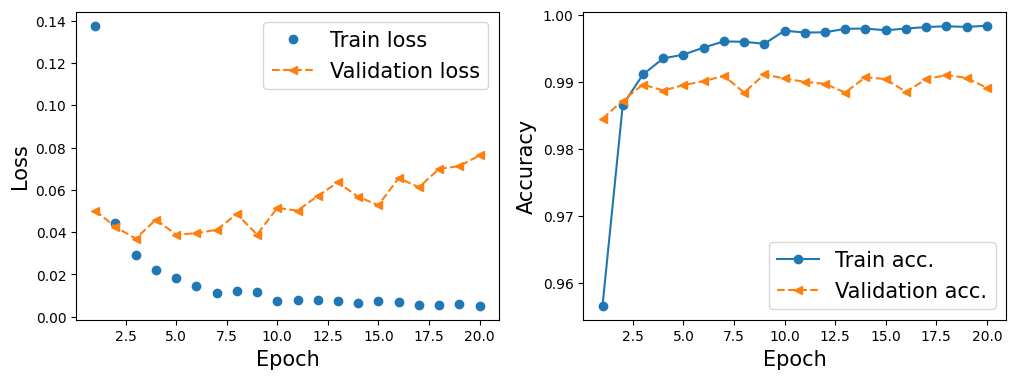

In [12]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'o',label='Train loss')
ax.plot(x_arr,hist['val_loss'],'--<', label='Validation loss')
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Loss',size = 15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['accuracy'],'-o',label='Train acc.')
ax.plot(x_arr,hist['val_accuracy'],'--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy',size=15)

In [13]:
test_results = model.evaluate(mnist_test.batch(20))
print('\n test accuracy {:.2f}%'.format(test_results[1]*100))

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9924 - loss: 0.0378

 test accuracy 99.17%


## Dự đoán nhãn dựa trên bộ test

In [ ]:
batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)
preds =tf.argmax(preds,axis=1)
print(preds)
# Vẽ ảnh
fig = plt.figure(figsize=(12,4))
for i in range(12):
    ax = fig.add_subplot(2,6,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = batch_test[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')
    ax.text(0.9,0.1,'{}'.format(preds[i]),size=15,color='b',horizontalalignment='center', verticalalignment='center',
    transform = ax.transAxes)
plt.show()